In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor
from tqdm import tqdm

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE, roc_auc_score as AUC_score
from sklearn import preprocessing

from classification_problem import Classification

In [19]:
def accuracy_score(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

def to_one_hot(category_array):
    ca = category_array # 1D array with values of the categories
    nr_categories = np.max(ca)+1
    nr_points = len(ca)
    one_hot = np.zeros((nr_points,nr_categories),dtype=int)
    one_hot[range(nr_points),ca] = 1
    return one_hot

def from_one_hot(one_hot_array):
    category_arr = np.nonzero(one_hot_array)[1]
    return category_arr

class NeuralNetwork:

    def __init__(
            self,
            X_data,
            Y_data,
            problem,    # input problem class, containing activiation functions and cost functions
            n_hidden_neurons_list =[2],    # list with numbers of neurons in each layer
            n_categories=10,    # nr output layer
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0,
            debug=False):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_layers = len(n_hidden_neurons_list)
        self.n_hidden_neurons_list = n_hidden_neurons_list
        self.n_categories = n_categories

        self.Problem = problem
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        
        self.debug = debug
        self.accuracy_each_epoch_train = np.zeros(epochs)
        self.accuracy_each_epoch_test = np.zeros(epochs)

        self.initialize_layers()

    def initialize_layers(self):
        n_hidden = self.n_hidden_neurons_list
        # Bias of layers l = [1,L-1]:
        self.bias_list = [np.zeros(n)+0.01 for n in n_hidden]
        # appending output layer:
        self.bias_list.append(np.zeros(self.n_categories)+0.01)
        
        # Weights for l = [1,L-1]:
        self.weights_list = [np.random.randn(self.n_features,n_hidden[0])]    # From input to l=1
        # Dimension of layers l dependenent on layer l-1:
        for i in range(1,self.n_layers):
            self.weights_list.append(np.random.randn(n_hidden[i-1],n_hidden[i]))
        # appending output layer:
        self.weights_list.append(np.random.randn(n_hidden[-1], self.n_categories))
    
    def printshape(self,x,name='x'):
        if isinstance(x,list):
            x = np.array(x)
        if self.debug:
            print('shape '+name,x.shape)
            
    def sigmoid(self,z):
        """ Returns sigmoid activation function for hidden layers """
        return 1/(1+np.exp(-z))

    def sigmoid_prime(self,z):
        """ Returns derivative of sigmoid """
        sigmoid = self.sigmoid(z)
        return sigmoid*(1-sigmoid)

    def softmax(self,z):
        """ Returns the softmax function """
        exp_term = np.exp(z)
        return exp_term/np.sum(exp_term, axis=1, keepdims=True)

    def feed_forward(self):
        """
        Feed forward loop used in training, looping all hidden layers and
        produces output probabilities for use in back propagation
        """
        problem = self.Problem
        # Input, Not using weights and biases for input layer
        self.a_list = [self.X_data]
        self.z_list = []

        self.printshape(self.a_list[-1],'input')
        
        # Loop through the layers, store weighted sum and activations
        i = 1
        for w,b in zip(self.weights_list,self.bias_list):
            
            self.z_list.append(np.matmul(self.a_list[-1],w)+b)         #np.matmul(self.a_list[-1],w)+b)
            self.a_list.append(self.sigmoid(self.z_list[-1]))
            
            self.printshape(w,'w'+str(i))
            self.printshape(b,'b'+str(i))
            self.printshape(self.a_list[-1],'a'+str(i))
            i+=1
        #del self.a_list[-1]
        if self.debug:
            print('len a_list',len(self.a_list))
            print('len z_list',len(self.z_list))
        self.probabilities = self.softmax(self.z_list[-1])

    def feed_forward_out(self, X):
        problem = self.Problem
        # Input, Not using weights and biases for input layer
        a_list = [X]
        z_list = []

        for w,b in zip(self.weights_list,self.bias_list):
            z_list.append(np.matmul(a_list[-1],w)+b)
            a_list.append(self.sigmoid(z_list[-1]))

        probabilities = self.softmax(z_list[-1])
        return probabilities

    def backpropagation(self):
        """
        Performs the back propagation algorithm, with output from forward pass
        in self.probabilities. Uses the expressions from the given Problem class
        to compute the output error.
        """
        ## Find errors from each layer: ##
        ## ---------------------------- ##
        error_list = []
        grad_w_list = []
        grad_b_list = []
        # Finds the output error (delta^L) using the given cost function from Problem

        self.printshape(self.probabilities,'prob',)
        self.printshape(self.Y_data,'Y_data',)
        
        output_error = self.Problem.output_error(self.probabilities,self.Y_data)
        error_list.append(output_error)
        self.printshape(output_error,'output error')
        delta = output_error
        
        # Propagate error back in the hidden layers to find error from each layer
        L = self.n_layers   # last layer number
                            # (usually not so high nr of layers, so looping multiple times for easy implementation)
        for l in range(2,L+2): 
            prev_error = error_list[-1]
            prev_w = self.weights_list[-l+1]
            current_z = self.z_list[-l]
            error_hidden = np.matmul(prev_error,prev_w.T)*self.sigmoid_prime(current_z)  # CHECK ORDER IN MATMUL?
            error_list.append(error_hidden)

        # Error_list is optained backwards, sorting to match layer numbers
        error_list.reverse()
        if self.debug:
            print('number of errors ',len(error_list))

        ## Find gradients from each layer: ##
        ## ------------------------------- ##
        
        if self.debug:
            print('n_layers',self.n_layers)
            print('n_a_list',len(self.a_list))
            print('n_w_list',len(self.weights_list))
        
        # Looping over all layers
        for l in range(self.n_layers):
            
            # Finding gradients (storing for now)
            grad_b_list.append(np.sum(error_list[l],axis=0))
            grad_w_list.append(np.matmul(self.a_list[l].T,error_list[l]))  # THE ERROR SEEMS TO BE HERE? SHOULD BE a_list[l-1]
            
            self.printshape(self.a_list[l-1].T,'a.T'+str(l))
            self.printshape(error_list[l],'error'+str(l+1))
            self.printshape(grad_w_list[l],'grad_w'+str(l+1))
            self.printshape(np.matmul(self.a_list[l-1].T,error_list[l]),'calc_grad_w'+str(l+1))
            self.printshape(grad_w_list[-1],'grad_w_o')

            if self.lmbd > 0.0: # If using regularization
                grad_w_list[l] += self.lmbd * self.weights_list[l]
    
            self.printshape(self.weights_list[l],'w'+str(l+1))
            self.printshape(grad_w_list[l],'grad_w'+str(l+1))
            
            # Update weights and biases
            self.weights_list[l] -= self.eta*grad_w_list[l]
            self.bias_list[l] -= self.eta*grad_b_list[l]
        
    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.feed_forward()
                self.backpropagation()
            self.accuracy_each_epoch_test[i] = accuracy_score(from_one_hot(Y_test),self.predict(X_test_scaled))
            self.accuracy_each_epoch_train[i] = accuracy_score(from_one_hot(self.Y_data_full),self.predict(self.X_data_full))


In [39]:
input_data = np.arange(0, 1000).reshape(1000,1)
output_data = np.zeros(len(input_data),dtype=int)
output_data[floor(len(input_data)/2):] = 1
output_one_hot = to_one_hot(output_data)
nr_params = output_one_hot.shape[1]
nr_datapoints = input_data.shape[0]; nr_datapoints,nr_params

(1000, 2)

In [45]:
np.random.seed(1)
n_points = 5000
x = np.arange(0,n_points)
y = np.random.randn(n_points)*25
input_data = np.c_[(x,y)]

output_data = np.zeros(n_points,dtype=int)
output_data[input_data[:,0]+input_data[:,1]>500] = 1
output_one_hot = to_one_hot(output_data)
nr_datapoints, nr_params = input_data.shape
print(nr_datapoints,nr_params)
input_data += np.random.randn(n_points,2)*25

5000 2


In [69]:
data_pd = pd.read_pickle("../data/credit_card_cleaned.pickle")
data = data_pd.to_numpy()[::10,:]
output = data[:,-1]
input_data = data[:,:-1]
print(output.shape, input_data.shape)
output_one_hot = to_one_hot(output)

(1932,) (1932, 23)


In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_one_hot)
Scaler = preprocessing.StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)

In [67]:
hidden_neuron_list = [16,16,16]
nn = NeuralNetwork( X_train_scaled,
                    Y_train,
                    problem = Classification,
                    n_hidden_neurons_list=hidden_neuron_list,
                    n_categories=2,
                    epochs=1000,
                    batch_size=400,
                    eta=1e-3,
                    lmbd=0.0,
                    debug=False)
nn.train()

0.772256728778468


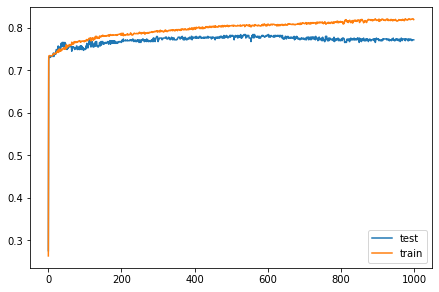

In [68]:
Y_pred = nn.predict(X_test_scaled)
print(accuracy_score(from_one_hot(Y_test),Y_pred))
plt.figure()
plt.plot(np.arange(nn.epochs),nn.accuracy_each_epoch_test,label='test')
plt.plot(np.arange(nn.epochs),nn.accuracy_each_epoch_train,label='train')
plt.legend()

In [49]:
def from_one_hot(one_hot_array):
    category_arr = np.nonzero(one_hot_array)[1]
    return category_arr

Y_pred = nn.predict(X_test_scaled)
accuracy_score(from_one_hot(Y_test),Y_pred)

0.9952

In [71]:
etas = np.logspace(-5,-1,6)
many_nns_only_eta = np.zeros(len(etas),dtype=object)
hidden_neuron_list = [16,16,16]
for i,eta in tqdm(enumerate(etas)):
    nn = NeuralNetwork(X_train_scaled,
                    Y_train,
                    problem = Classification,
                    n_hidden_neurons_list=hidden_neuron_list,
                    n_categories=2,
                    epochs=1000,
                    batch_size=250,
                    eta=eta,
                    lmbd=0.0,
                    debug=False)
    nn.train()
    many_nns_only_eta[i] = nn


6it [00:38,  6.34s/it]


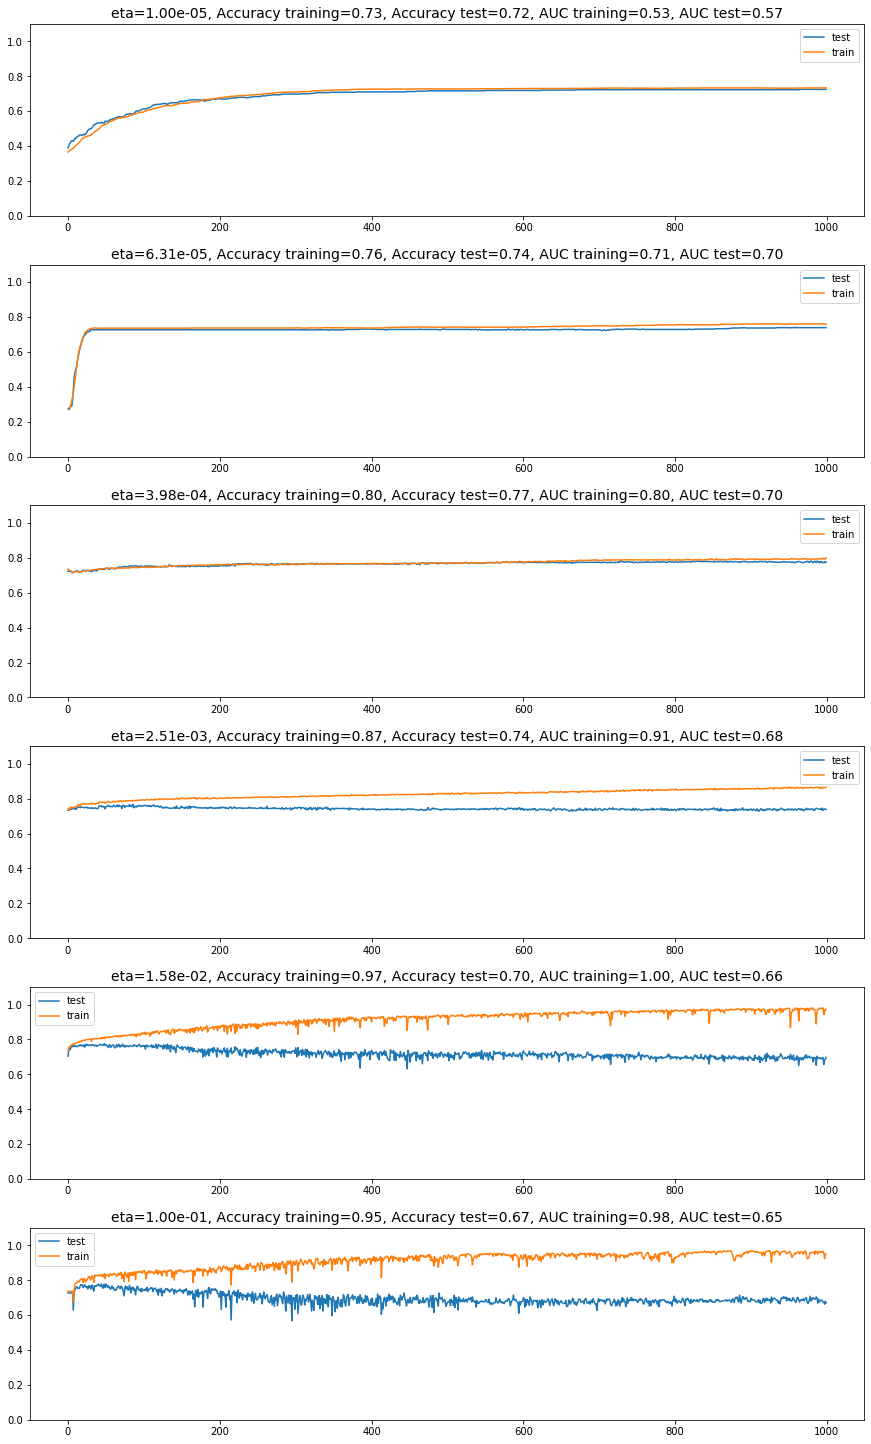

In [72]:
fig,ax = plt.subplots(len(etas),figsize=(12,20))
for i,eta in enumerate(etas):
    current = many_nns_only_eta[i]
    Y_pred_train = current.predict_probabilities(X_train_scaled)
    Y_pred_test = current.predict_probabilities(X_test_scaled)
    AUC_train = AUC_score(Y_train,Y_pred_train)
    AUC_test = AUC_score(Y_test,Y_pred_test)
    ax[i].plot(current.accuracy_each_epoch_test,label='test')
    ax[i].plot(current.accuracy_each_epoch_train,label='train')
    ax[i].legend()
    ax[i].set_title('eta={:.2e}, Accuracy training={:.2f}, Accuracy test={:.2f}, AUC training={:.2f}, AUC test={:.2f}'.format(eta,current.accuracy_each_epoch_train[-1],current.accuracy_each_epoch_test[-1],AUC_train,AUC_test),fontsize=14)
    ax[i].set_ylim(0,1.1)

In [533]:
class NeuralNetwork2:

    def __init__(
            self,
            X_data,
            Y_data,
            problem,    # input problem class, containing activiation functions and cost functions
            n_hidden_neurons_list =[2],    # list with numbers of neurons in each layer
            n_categories=10,    # nr output layer
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0,
            debug=False):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_hidden_layers = len(n_hidden_neurons_list)
        self.n_hidden_neurons_list = n_hidden_neurons_list
        self.n_categories = n_categories

        self.Problem = problem
        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd
        
        self.debug = debug
        self.accuracy_each_epoch_train = np.zeros(epochs)
        self.accuracy_each_epoch_test = np.zeros(epochs)

        self.initialize_layers()

    def initialize_layers(self):
        n_hidden = self.n_hidden_neurons_list
        # Bias of hidden layers 
        self.hidden_bias_list = [np.zeros(n)+0.01 for n in n_hidden]
        # output layer:
        self.output_bias = (np.zeros(self.n_categories)+0.01)
        
        # Weights for hidden layers
        self.hidden_weights_list = [np.random.randn(self.n_features,n_hidden[0])]    # From input to l=1
        # Dimension of layers l dependenent on layer l-1:
        for i in range(1,self.n_hidden_layers):
            self.hidden_weights_list.append(np.random.randn(n_hidden[i-1],n_hidden[i]))
        # appending output layer:
        self.output_weights = (np.random.randn(n_hidden[-1], self.n_categories))
    
    def printshape(self,x,name='x'):
        if isinstance(x,list):
            x = np.array(x)
        if self.debug:
            print('shape '+name,x.shape)
            
    def sigmoid(self,z):
        """ Returns sigmoid activation function for hidden layers """
        return 1/(1+np.exp(-z))

    def sigmoid_prime(self,z):
        """ Returns derivative of sigmoid """
        return self.sigmoid(z)*(1-self.sigmoid(z))

    def softmax(self,z):
        """ Returns the softmax function """
        exp_term = np.exp(z)
        return exp_term/np.sum(exp_term, axis=1, keepdims=True)

    def feed_forward(self):
        """
        Feed forward loop used in training, looping all hidden layers and
        produces output probabilities for use in back propagation
        """
        # Input, Not using weights and biases for input layer
        self.a_list = [self.X_data]
        self.z_list = [np.array([0])]

        self.printshape(self.a_list[-1],'input')
        
        # Loop through the layers, store weighted sum and activations
        i = 1
        for w,b in zip(self.hidden_weights_list,self.hidden_bias_list):
            
            self.z_list.append(np.matmul(self.a_list[-1],w)+b)
            self.a_list.append(self.sigmoid(self.z_list[-1]))
            
            self.printshape(w,'w'+str(i))
            self.printshape(b,'b'+str(i))
            self.printshape(self.a_list[-1],'a'+str(i))
            i+=1

        self.z_list.append(np.matmul(self.a_list[-1],self.output_weights)+self.output_bias)
        self.a_list.append(self.softmax(self.z_list[-1]))
        self.probabilities = self.a_list[-1]

        if self.debug:
            print('len a_list',len(self.a_list))
            print('len z_list',len(self.z_list))

    def feed_forward_out(self, X):
           # Input, Not using weights and biases for input layer
        a_list = [self.X_data]
        z_list = [np.array([0])]

        self.printshape(a_list[-1],'input')
        
        # Loop through the layers, store weighted sum and activations
        i = 1
        for w,b in zip(self.hidden_weights_list,self.hidden_bias_list):
            
            z_list.append(np.matmul(a_list[-1],w)+b)
            a_list.append(self.sigmoid(z_list[-1]))
            
            self.printshape(w,'w'+str(i))
            self.printshape(b,'b'+str(i))
            self.printshape(a_list[-1],'a'+str(i))
            i+=1

        z_list.append(np.matmul(a_list[-1],self.output_weights)+self.output_bias)
        a_list.append(self.softmax(z_list[-1]))
        probabilities = a_list[-1]
        return probabilities

    def backpropagation(self):
        """
        Performs the back propagation algorithm, with output from forward pass
        in self.probabilities. Uses th expressions from the given Problem class
        to compute the output error.
        """
        ## Find errors from each layer: ##
        ## ---------------------------- ##
        error_list = []
        grad_w_list = []
        grad_b_list = []
        grad_w_output = 0
        grad_b_output = 0

        self.printshape(self.probabilities,'prob',)
        self.printshape(self.Y_data,'Y_data',)
        
        # Finds the output error (delta^L) using the given cost function from Problem
        output_error = self.Problem.output_error(self.probabilities,self.Y_data)
        error_list.append(output_error)
        self.printshape(output_error,'output error')
        delta = output_error
        
        # Propagate error back in the hidden layers to find error from each layer
        # (usually not so high nr of layers, so looping multiple times for easy implementation)
        for l in range(2,self.n_hidden_layers+2): 
            prev_error = error_list[-1]
            prev_w = self.hidden_weights_list[-l+1]
            prev_a = self.a_list[-l-1]
            current_z = self.z_list[-l]
            error_hidden = np.matmul(prev_error,prev_w.T)*self.sigmoid_prime(current_z)  # CHECK ORDER IN MATMUL?
            error_list.append(error_hidden)
            grad_b_list.append(np.sum(error_hidden,axis=0))
            grad_w_list.append(np.matmul(prev_a.T,error_hidden))


        # Error_list is optained backwards, sorting to match layer numbers
        error_list.reverse()
        grad_b_list.reverse()
        grad_w_list.reverse()
        for l in range(len(grad_w_list)):
            self.printshape('error',error_list[l])
            self.printshape('grad b',grad_b_list[l])
            self.printshape('grad w',grad_w_list[l])
        if self.debug:
            print('number of errors ',len(error_list))

        ## Find gradients from each layer: ##
        ## ------------------------------- ##
        
        if self.debug:
            print('n_hidden_layers',self.n_hidden_layers)
            print('n_a_list',len(self.a_list))
            print('n_w_list',len(self.weights_list))
        
        # Looping over all layers
        for l in range(self.n_hidden_layers):
            
            # Finding gradients (storing for now)
            grad_b_list.append(np.sum(error_list[l],axis=0))
            grad_w_list.append(np.matmul(self.a_list[l-1].T,error_list[l]))
            
            self.printshape(self.a_list[l-1].T,'a.T'+str(l))
            self.printshape(error_list[l],'error'+str(l+1))
            self.printshape(grad_w_list[l],'grad_w'+str(l+1))
            self.printshape(np.matmul(self.a_list[l-1].T,error_list[l]),'calc_grad_w'+str(l+1))
            self.printshape(grad_w_list[-1],'grad_w_o')

            if self.lmbd > 0.0: # If using regularization
                grad_w_list[l] += self.lmbd * self.weights_list[l]
    
            self.printshape(self.weights_list[l],'w'+str(l+1))
            self.printshape(grad_w_list[l],'grad_w'+str(l+1))
            
            # Update weights and biases
            self.weights_list[l] -= self.eta*grad_w_list[l]
            self.bias_list[l] -= self.eta*grad_b_list[l]
        
    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in range(self.epochs):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.feed_forward()
                self.backpropagation()
            self.accuracy_each_epoch_test[i] = accuracy_score(from_one_hot(Y_test),self.predict(X_test_scaled))
            self.accuracy_each_epoch_train[i] = accuracy_score(from_one_hot(self.Y_data_full),self.predict(self.X_data_full))


In [532]:
hidden_neuron_list = [8,6,4]
nn2 = NeuralNetwork2( X_train_scaled,
                    Y_train,
                    problem = Classification,
                    n_hidden_neurons_list=hidden_neuron_list,
                    n_categories=2,
                    epochs=500,
                    batch_size=20,
                    eta=1e-3,
                    lmbd=0.0,
                    debug=True)
nn2.train()

shape input (20, 1)
shape w1 (1, 8)
shape b1 (8,)
shape a1 (20, 8)
shape w2 (8, 6)
shape b2 (6,)
shape a2 (20, 6)
shape w3 (6, 4)
shape b3 (4,)
shape a3 (20, 4)
len a_list 5
len z_list 5
shape prob (20, 2)
shape Y_data (20, 2)
shape output error (20, 2)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 20 is different from 6)